In [22]:
# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# You only need to authenticate once per session.
auth.authenticate_user()

In [23]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_gbq
import seaborn as sns

# below imports are used for pretty pandas dataframes and plots
from IPython.display import display, HTML
%matplotlib inline
plt.style.use('ggplot')

# Set up environment variables
project_id = 'genuine-box-350018'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id
pandas_gbq.context.project = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
    return pd.io.gbq.read_gbq(
        query,
        project_id=project_id,
        dialect="standard"
    )

if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project at the top of this cell.')

  # test it works
df = run_query("""
SELECT *
FROM `physionet-data.mimic_core.patients`
WHERE subject_id = 10012853
""")
assert df.shape[0] >= 1, 'unable to query MIMIC!'
display(df)


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10012853,F,91,2175,2014 - 2016,NaT


In [24]:
input_data = run_query(f'''
SELECT *
FROM `genuine-box-350018.rnn_dataset.timeseries-input-table` 
''')
display(input_data)


,subject_id,hadm_id,stay_id,hour,covariate,amount
0,13762560,23892460,39736584,5,Packed Red Blood Cells,350.000010
1,13762560,23892460,39736584,8,Packed Red Blood Cells,350.000010
2,13762560,23892460,39736584,9,Calcium Gluconate,2.000000
3,13762560,23892460,39736584,9,Piggyback,99.999998
4,13762560,23892460,39736584,10,PO Intake,40.000000
...,...,...,...,...,...,...
493600,17299199,26943137,39986042,26,Insulin - Regular,8.000000
493601,15465215,20621314,34764910,2,Dextrose 5%,100.000005
493602,15465215,20621314,34764910,14,Dextrose 5%,69.583337
493603,15465215,20621314,34764910,18,D5 1/2NS,99.999997


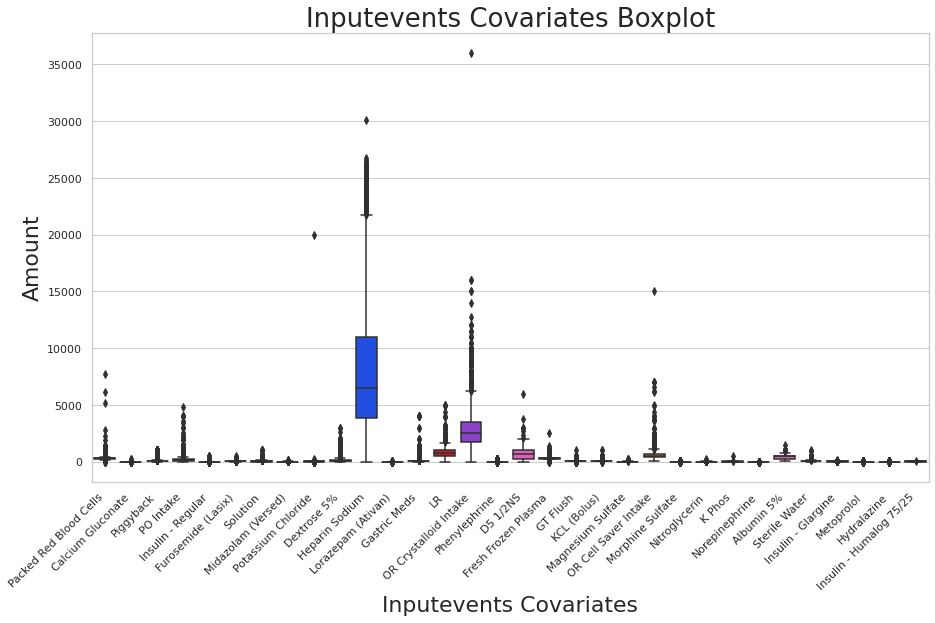

In [4]:
# Exploring any outlier amounts
sns.set(style="whitegrid", font_scale=1, rc={'figure.figsize':(15,8.27)})
sns.boxplot(x='covariate', y='amount', data=input_data, palette="bright")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Inputevents Covariates", fontsize=22)
plt.ylabel("Amount", fontsize=22)
plt.title("Inputevents Covariates Boxplot", fontsize=26)
plt.show(sns)

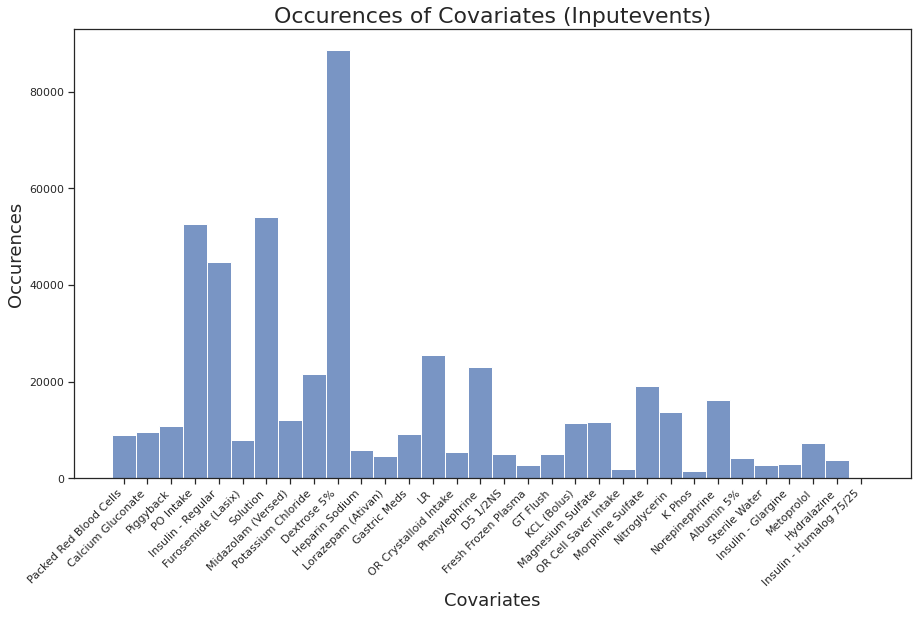

In [59]:
# Plotting occurence of each covariate
sns.set(style="ticks", font_scale=1)
sns.histplot(data=input_data, x='covariate', palette="dark")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Covariates", fontsize=18)
plt.ylabel("Occurences", fontsize=18)
plt.title("Occurences of Covariates (Inputevents)", fontsize=22)
plt.show(sns)

In [42]:
print(min(input_data['hour']))
print(max(input_data['hour']))

-4
49


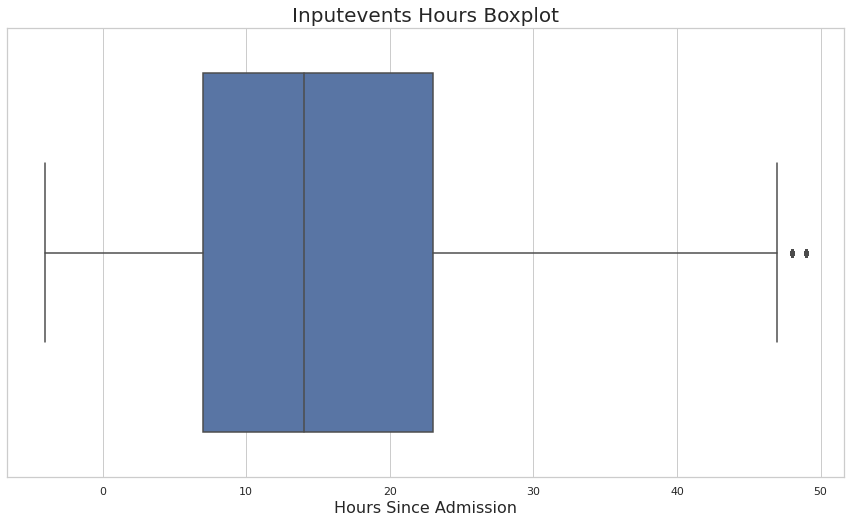

In [28]:
# Boxplot of hours (starttime - admittime)
sns.set(style="whitegrid", font_scale=1, rc={'figure.figsize':(15,8.27)})
sns.boxplot(x=input_data['hour'])
plt.xlabel("Hours Since Admission", fontsize=16)
plt.title("Inputevents Hours Boxplot", fontsize=20)
plt.show(sns)

In [29]:
input_data[input_data['hour']<0]

,subject_id,hadm_id,stay_id,hour,covariate,amount
12699,19165446,21796472,32223448,-1,Dextrose 5%,57.000002
12700,19165446,21796472,32223448,-1,Heparin Sodium,5699.999783
13782,15319814,28202510,37243335,-1,Packed Red Blood Cells,281.000004
21242,19544330,25186323,32438211,-1,Packed Red Blood Cells,374.999991
28727,14768910,27747532,31100931,-1,Midazolam (Versed),3.500000
...,...,...,...,...,...,...
488843,10578941,28771931,36427560,-2,Dextrose 5%,157.352941
488844,10578941,28771931,36427560,-2,Nitroglycerin,62.941176
488845,10578941,28771931,36427560,-1,Metoprolol,5.000000
489067,17794301,21140176,34673207,-1,Solution,81.333338


In [30]:
input_data[input_data['hour']>48]

,subject_id,hadm_id,stay_id,hour,covariate,amount
8707,13792260,24304394,32349733,49,Norepinephrine,1.302655
8708,13792260,24304394,32349733,49,Phenylephrine,9.203540
17433,11235080,23814635,30289380,49,Metoprolol,5.000000
22312,16759306,25021094,30914653,49,Solution,13.270779
23073,19872267,26506881,31321104,49,PO Intake,60.000000
...,...,...,...,...,...,...
462795,18951152,28977250,30191849,49,Morphine Sulfate,2.000000
468467,17509107,25893958,33499859,49,Piggyback,99.999998
476716,14482934,29540900,39768103,49,Metoprolol,5.000000
488913,19229949,25235460,39604334,49,PO Intake,60.000000


In [32]:
input_data['hour'] = np.where((input_data.hour < 0), 0, input_data.hour)
input_data['hour'] = np.where((input_data.hour > 48), 48, input_data.hour)

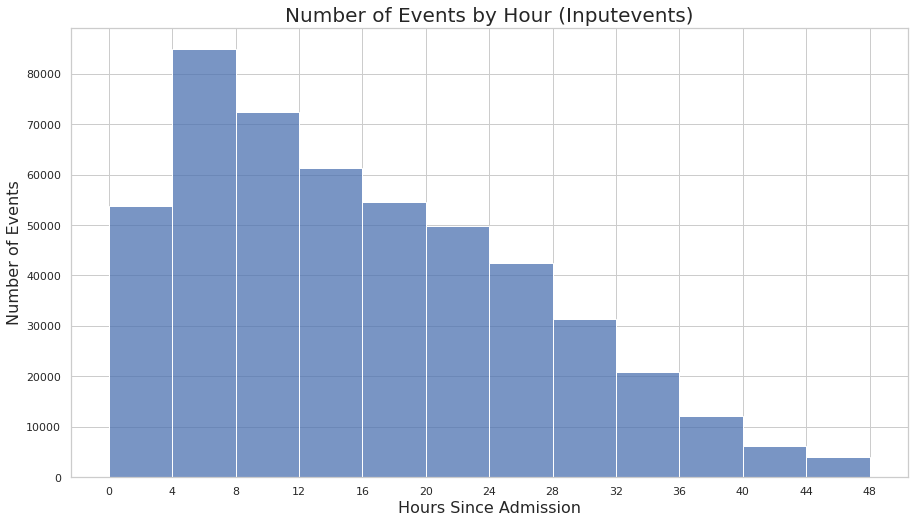

In [33]:
# Plotting events by hours (starttime - admittime)
fig, ax = plt.subplots()
sns.set(style="ticks", font_scale=1)
sns.histplot(data=input_data, x='hour', bins=12, ax=ax)
ax.set_xticks(range(0,52,4))
plt.xlabel("Hours Since Admission", fontsize=16)
plt.ylabel("Number of Events", fontsize=16)
plt.title("Number of Events by Hour (Inputevents)", fontsize=20)
plt.show(sns)

In [34]:
output_data = run_query(f'''
SELECT *
FROM `genuine-box-350018.rnn_dataset.timeseries-output-table` 
''')
display(output_data)


,subject_id,hadm_id,stay_id,hour,covariate,value
0,13762560,23892460,39736584,9,Void,100.0
1,19072000,28969811,39514141,1,Foley,280.0
2,19072000,28969811,39514141,2,Foley,330.0
3,19072000,28969811,39514141,3,Foley,450.0
4,19072000,28969811,39514141,4,Foley,370.0
...,...,...,...,...,...,...
471548,17299199,26943137,39986042,24,Chest Tube #1,20.0
471549,15465215,20621314,34764910,16,Void,280.0
471550,15465215,20621314,34764910,25,Void,350.0
471551,15465215,20621314,34764910,3,Pre-Admission,800.0


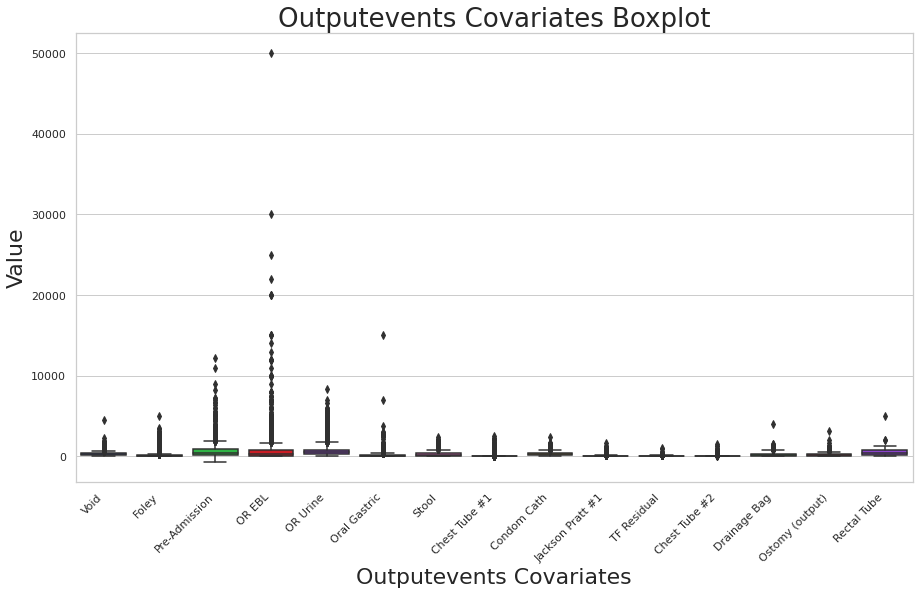

In [35]:
# Exploring any outlier amounts
sns.set(style="whitegrid", font_scale=1, rc={'figure.figsize':(15,8.27)})
sns.boxplot(x='covariate', y='value', data=output_data, palette="bright")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Outputevents Covariates", fontsize=22)
plt.ylabel("Value", fontsize=22)
plt.title("Outputevents Covariates Boxplot", fontsize=26)
plt.show(sns)

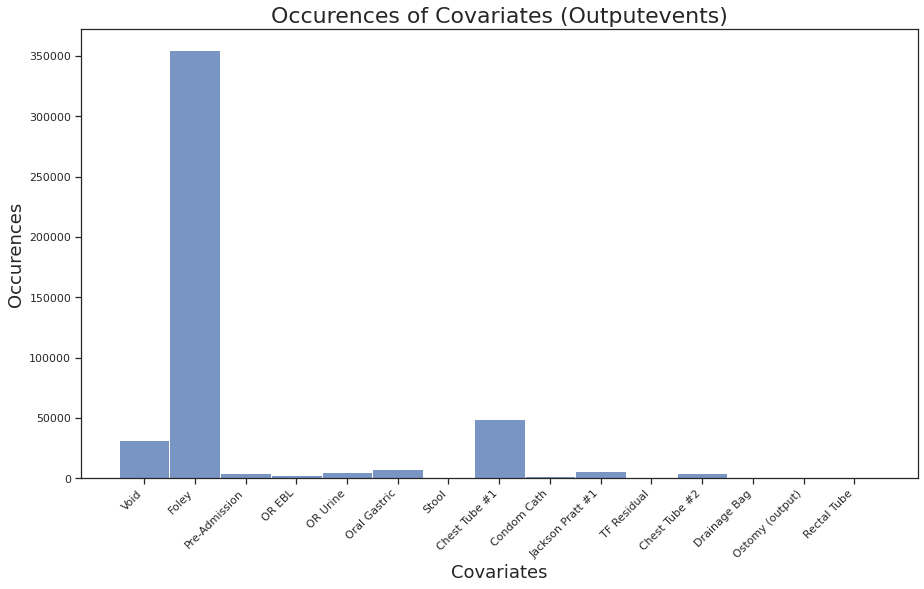

In [60]:
# Plotting occurence of each covariate
sns.set(style="ticks", font_scale=1)
sns.histplot(data=output_data, x='covariate', palette="dark")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Covariates", fontsize=18)
plt.ylabel("Occurences", fontsize=18)
plt.title("Occurences of Covariates (Outputevents)", fontsize=22)
plt.show(sns)

In [36]:
print(min(output_data['hour']))
print(max(output_data['hour']))

-715
49


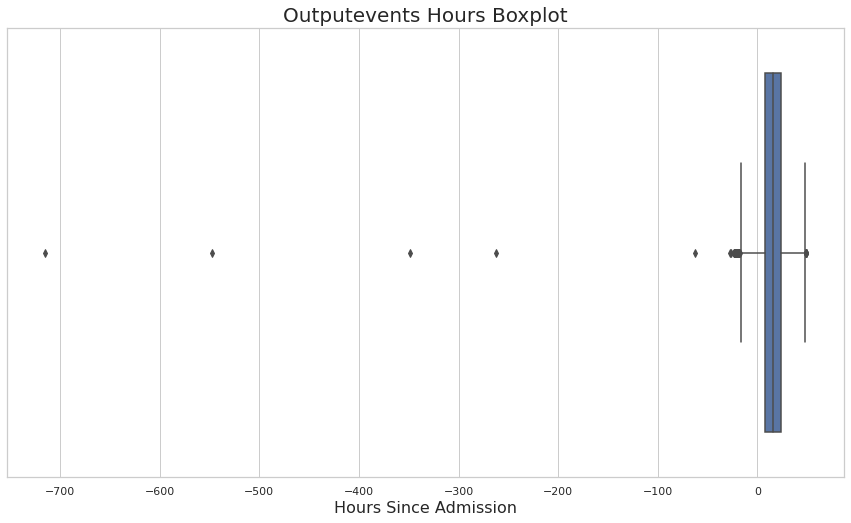

In [53]:
# Boxplot of hours (charttime - admittime)
sns.set(style="whitegrid", font_scale=1)
sns.boxplot(x=output_data['hour'])
plt.xlabel("Hours Since Admission", fontsize=16)
plt.title("Outputevents Hours Boxplot", fontsize=20)
plt.show(sns)

In [37]:
output_data[output_data['hour']<0]

,subject_id,hadm_id,stay_id,hour,covariate,value
71,11343360,27797947,37574767,-5,Foley,300.0
2654,11178753,25733316,38349010,-22,Void,1.0
2905,12308993,26386400,37324626,-1,Foley,480.0
8539,13415172,22464949,33466437,-262,Pre-Admission,625.0
9420,19611909,26061152,37946973,-715,Foley,100.0
...,...,...,...,...,...,...
451252,12775924,27194337,31637800,-1,Foley,400.0
452909,19715573,28578075,37045615,-19,Foley,60.0
457211,19992312,25379817,30412504,-1,Foley,300.0
461989,11517178,21124974,36693551,-1,Foley,1700.0


In [38]:
output_data[output_data['hour']>48]

,subject_id,hadm_id,stay_id,hour,covariate,value
16490,11235080,23814635,30289380,49,Foley,150.0
23991,12288012,24599555,36739121,49,Foley,50.0
125946,10242627,23198896,35070704,49,OR EBL,1500.0
125947,10242627,23198896,35070704,49,OR Urine,5020.0
242276,16167811,21412149,33571339,49,Foley,40.0
251888,10828425,24057066,31393514,49,Foley,100.0
404562,16686811,20925347,39666892,49,TF Residual,10.0
413797,10779360,28826027,34316065,49,Foley,100.0
424527,16948966,21160164,35298321,49,Foley,200.0


In [39]:
output_data['hour'] = np.where((output_data.hour < 0), 0, output_data.hour)
output_data['hour'] = np.where((output_data.hour > 48), 48, output_data.hour)

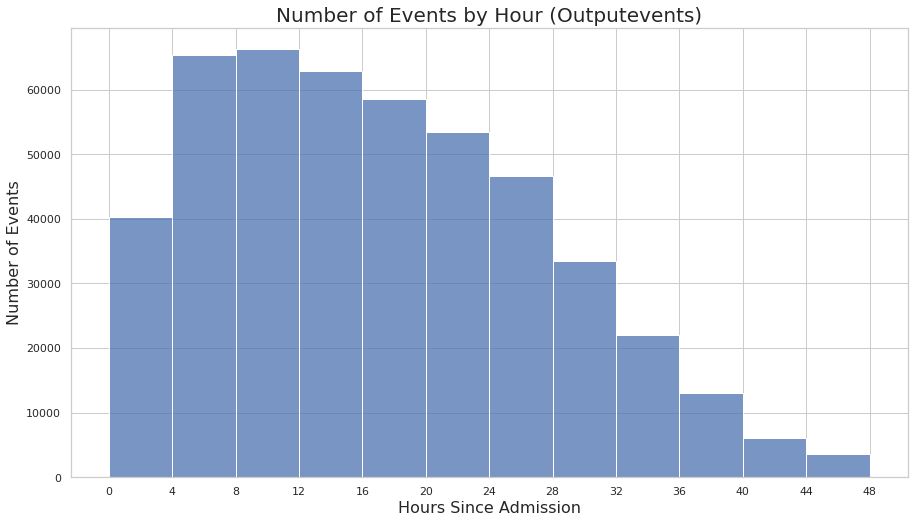

In [40]:
# Plotting events by hours (charttime - admittime)
fig, ax = plt.subplots()
sns.set(style="ticks", font_scale=1)
sns.histplot(data=output_data, x='hour',bins=12, ax=ax)
ax.set_xticks(range(0,52,4))
plt.xlabel("Hours Since Admission", fontsize=16)
plt.ylabel("Number of Events", fontsize=16)
plt.title("Number of Events by Hour (Outputevents)", fontsize=20)
plt.show(sns)

In [41]:
lab_data = run_query(f'''
SELECT *
FROM `genuine-box-350018.rnn_dataset.timeseries-lab-table` 
''')
display(lab_data)


,subject_id,hadm_id,stay_id,hour,covariate,valuenum_min,valuenum_max
0,10000980,26913865,39765666,12,PT,14.50,14.50
1,10000980,26913865,39765666,12,PTT,69.60,69.60
2,10000980,26913865,39765666,22,Anion Gap,17.00,17.00
3,10000980,26913865,39765666,22,Bicarbonate,23.00,23.00
4,10000980,26913865,39765666,22,"Calcium, Total",9.20,9.20
...,...,...,...,...,...,...,...
2072410,19999987,23865745,36195440,7,Base Excess,1.00,1.00
2072411,19999987,23865745,36195440,7,Calculated Total CO2,28.00,28.00
2072412,19999987,23865745,36195440,7,pCO2,44.00,44.00
2072413,19999987,23865745,36195440,7,pH,7.39,7.39


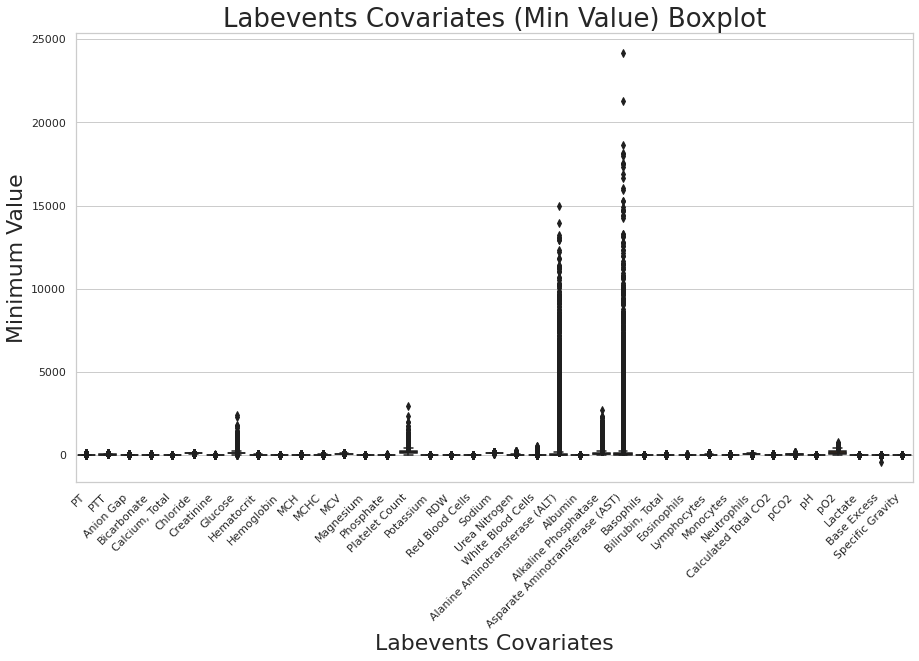

In [44]:
# Exploring minimum values
sns.set(style="whitegrid", font_scale=1, rc={'figure.figsize':(15,8.27)})
sns.boxplot(x='covariate', y='valuenum_min', data=lab_data, palette="dark")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Labevents Covariates", fontsize=22)
plt.ylabel("Minimum Value", fontsize=22)
plt.title("Labevents Covariates (Min Value) Boxplot", fontsize=26)
plt.show(sns)

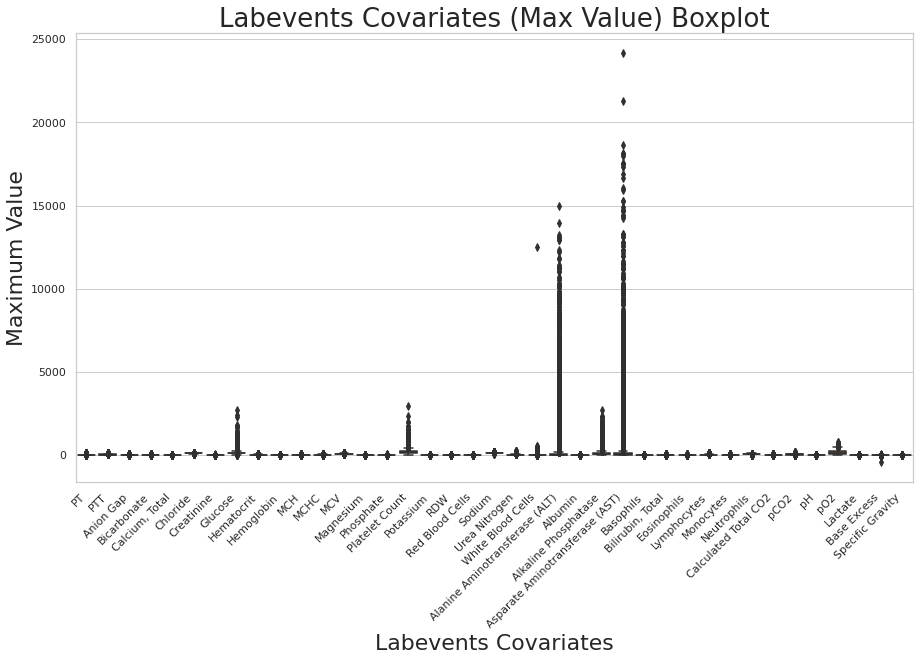

In [46]:
# Exploring maximum value
sns.set(style="whitegrid", font_scale=1, rc={'figure.figsize':(15,8.27)})
sns.boxplot(x='covariate', y='valuenum_max', data=lab_data, palette="bright")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Labevents Covariates", fontsize=22)
plt.ylabel("Maximum Value", fontsize=22)
plt.title("Labevents Covariates (Max Value) Boxplot", fontsize=26)
plt.show(sns)

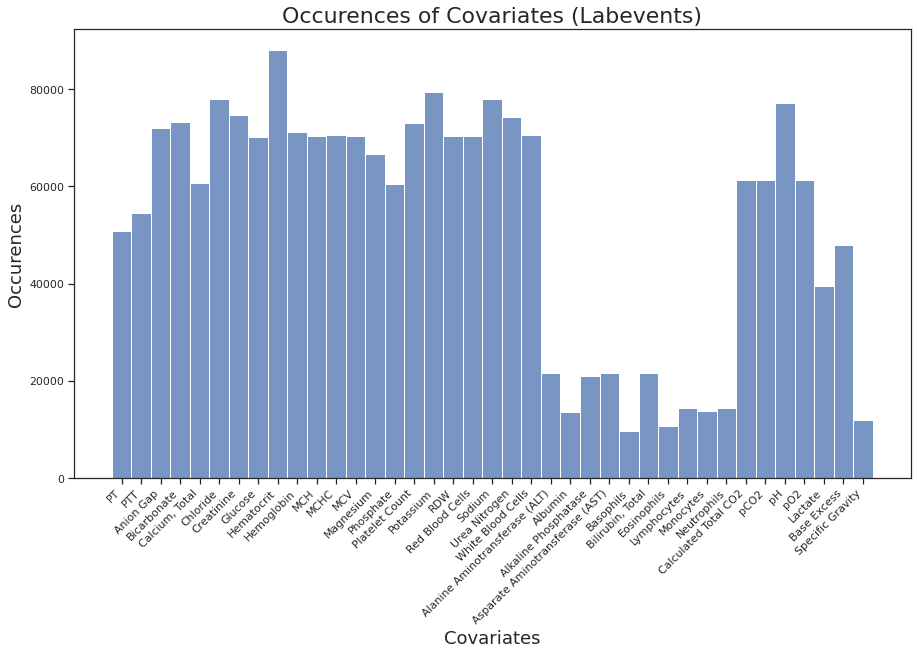

In [62]:
# Plotting occurence of each covariate
sns.set(style="ticks", font_scale=1)
sns.histplot(data=lab_data, x='covariate', palette="dark")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Covariates", fontsize=18)
plt.ylabel("Occurences", fontsize=18)
plt.title("Occurences of Covariates (Labevents)", fontsize=22)
plt.show(sns)

In [47]:
print(min(lab_data['hour']))
print(max(lab_data['hour']))

-2549
49


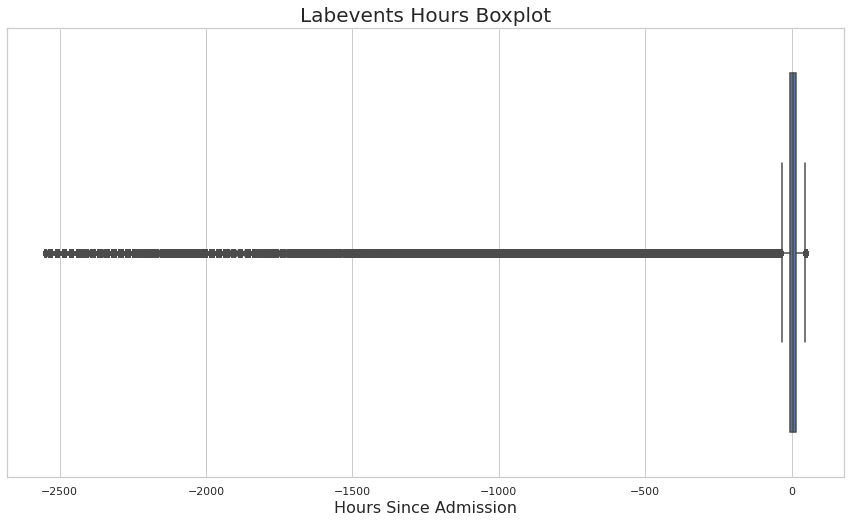

In [48]:
# Boxplot of hours (charttime - admittime)
sns.set(style="whitegrid", font_scale=1)
sns.boxplot(x=lab_data['hour'])
plt.xlabel("Hours Since Admission", fontsize=16)
plt.title("Labevents Hours Boxplot", fontsize=20)
plt.show(sns)

In [49]:
lab_data[lab_data['hour']<0]

,subject_id,hadm_id,stay_id,hour,covariate,valuenum_min,valuenum_max
53,10001217,24597018,37067082,-11,Creatinine,0.70,0.70
54,10001217,24597018,37067082,-5,Anion Gap,16.00,16.00
55,10001217,24597018,37067082,-5,Bicarbonate,22.00,22.00
56,10001217,24597018,37067082,-5,"Calcium, Total",7.90,7.90
57,10001217,24597018,37067082,-5,Chloride,108.00,108.00
...,...,...,...,...,...,...,...
2072298,19999840,21033226,38978960,-2,RDW,14.20,14.20
2072299,19999840,21033226,38978960,-2,Red Blood Cells,4.91,4.91
2072300,19999840,21033226,38978960,-2,Sodium,140.00,140.00
2072301,19999840,21033226,38978960,-2,Urea Nitrogen,19.00,19.00


In [50]:
lab_data[lab_data['hour']>48]

,subject_id,hadm_id,stay_id,hour,covariate,valuenum_min,valuenum_max
9065,10048723,25762910,36542901,49,Sodium,162.00,162.00
164019,10828425,24057066,31393514,49,Sodium,148.00,148.00
165215,10835593,28296785,37215446,49,pH,7.39,7.39
167052,10839034,29535095,30776850,49,Alanine Aminotransferase (ALT),22.00,22.00
167053,10839034,29535095,30776850,49,Albumin,2.30,2.30
...,...,...,...,...,...,...,...
2008520,19682968,22000460,30069861,49,Base Excess,4.00,4.00
2008521,19682968,22000460,30069861,49,Calculated Total CO2,31.00,31.00
2008522,19682968,22000460,30069861,49,pCO2,49.00,49.00
2008523,19682968,22000460,30069861,49,pH,7.40,7.40


In [51]:
lab_data['hour'] = np.where((lab_data.hour < 0), 0, lab_data.hour)
lab_data['hour'] = np.where((lab_data.hour > 48), 48, lab_data.hour)

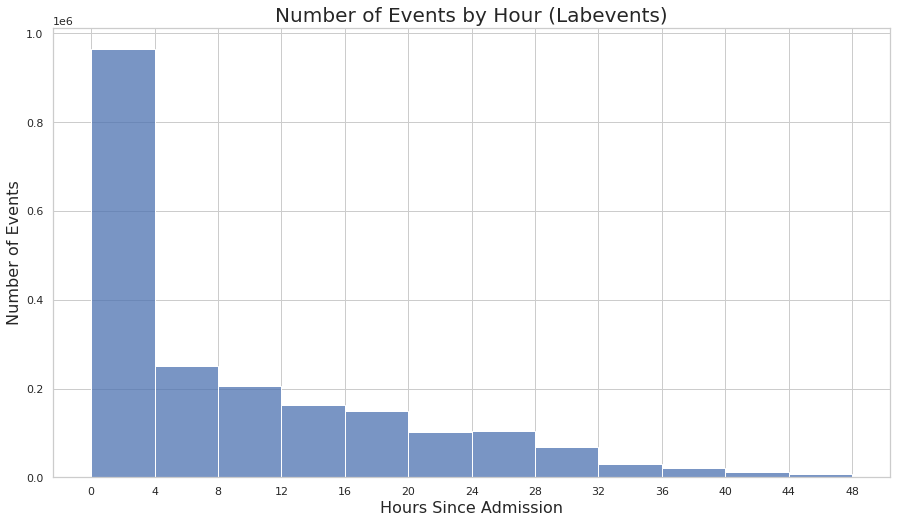

In [52]:
# Plotting events by hours (charttime - admittime)
fig, ax = plt.subplots()
sns.set(style="ticks", font_scale=1)
sns.histplot(data=lab_data, x='hour',bins=12, ax=ax)
ax.set_xticks(range(0,52,4))
plt.xlabel("Hours Since Admission", fontsize=16)
plt.ylabel("Number of Events", fontsize=16)
plt.title("Number of Events by Hour (Labevents)", fontsize=20)
plt.show(sns)

In [53]:
drug = run_query(f'''
SELECT *
FROM `genuine-box-350018.rnn_dataset.timeseries-pres-table` 
''')
display(drug)


,subject_id,hadm_id,stay_id,hour,covariate,dose
0,10000980,26913865,39765666,3,Aspirin,81.0
1,10000980,26913865,39765666,12,Metoprolol Tartrate,12.5
2,10001217,24597018,37067082,-42,Bisacodyl,20.0
3,10001217,24597018,37067082,-42,Docusate Sodium,100.0
4,10001725,25563031,31205490,0,Docusate Sodium,100.0
...,...,...,...,...,...,...
99907,19999840,21033226,38978960,-47,Aspirin,381.0
99908,19999840,21033226,38978960,-3,Metoprolol Tartrate,5.0
99909,19999840,21033226,38978960,20,Potassium Chloride,120.0
99910,19999840,21033226,38978960,30,Bisacodyl,20.0


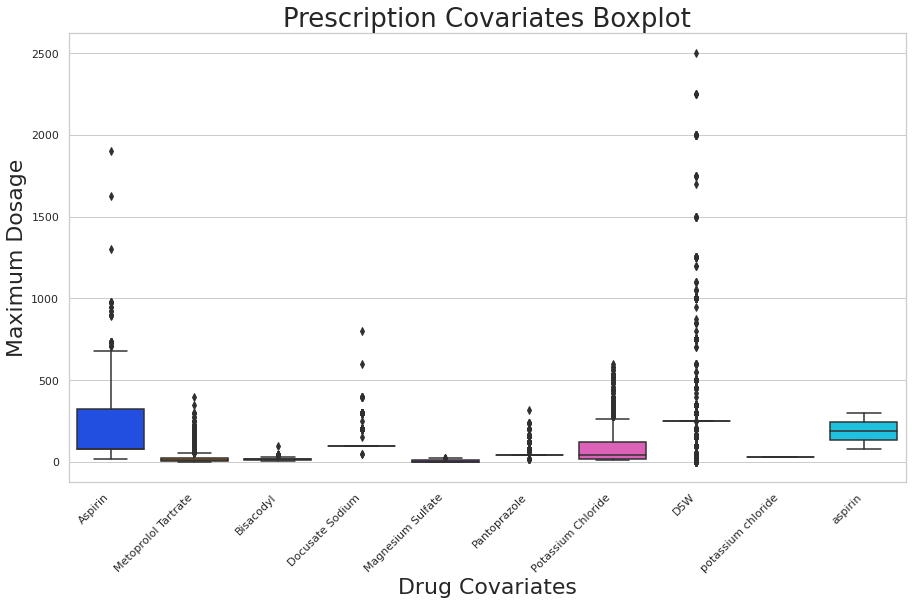

In [55]:
# Exploring outliers (dose is max dosage)
sns.set(style="whitegrid", font_scale=1, rc={'figure.figsize':(15,8.27)})
sns.boxplot(x='covariate', y='dose', data=drug, palette="bright")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Drug Covariates", fontsize=22)
plt.ylabel("Maximum Dosage", fontsize=22)
plt.title("Prescription Covariates Boxplot", fontsize=26)
plt.show(sns)

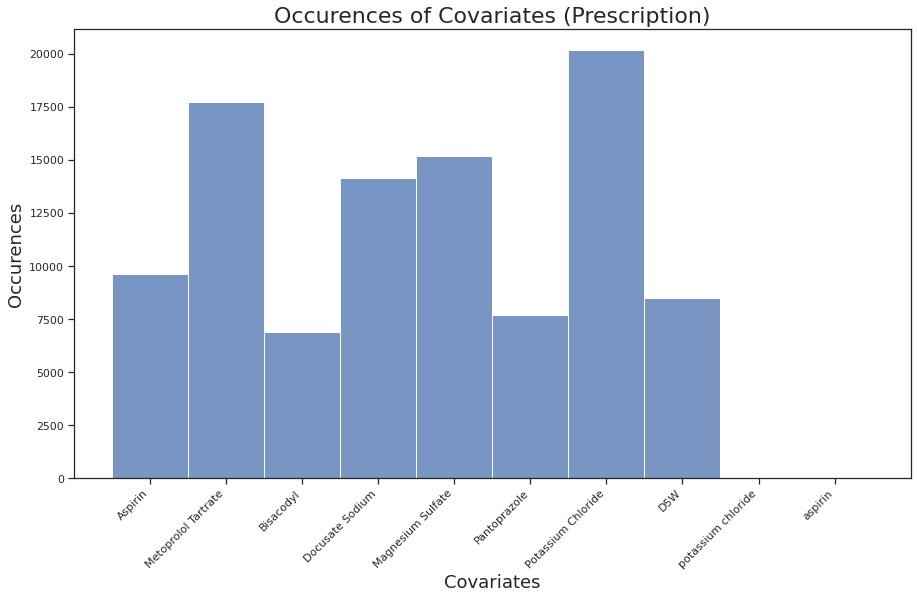

In [63]:
# Plotting occurence of each covariate
sns.set(style="ticks", font_scale=1)
sns.histplot(data=drug, x='covariate', palette="dark")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Covariates", fontsize=18)
plt.ylabel("Occurences", fontsize=18)
plt.title("Occurences of Covariates (Prescription)", fontsize=22)
plt.show(sns)

In [64]:
print(min(drug['hour']))
print(max(drug['hour']))

-2543
48


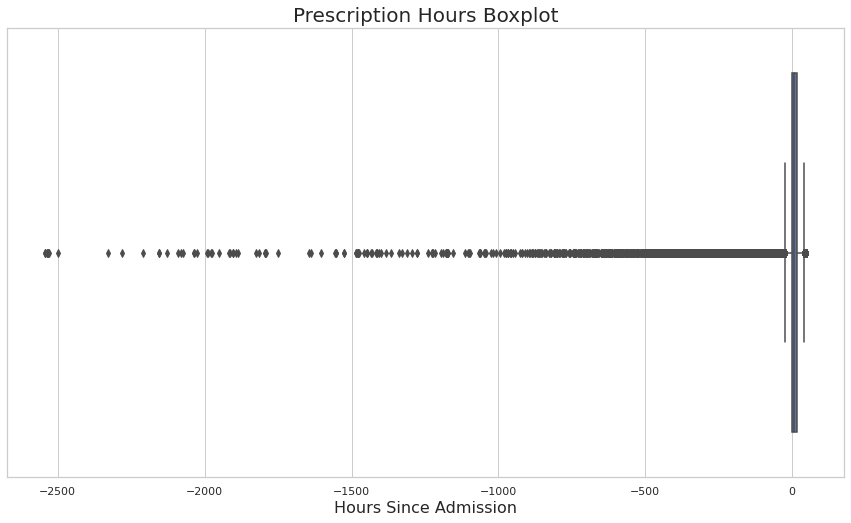

In [65]:
# Boxplot of hours (starttime - admittime)
sns.set(style="whitegrid", font_scale=1)
sns.boxplot(x=drug['hour'])
plt.xlabel("Hours Since Admission", fontsize=16)
plt.title("Prescription Hours Boxplot", fontsize=20)
plt.show(sns)

In [66]:
drug[drug['hour']<0]

,subject_id,hadm_id,stay_id,hour,covariate,dose
2,10001217,24597018,37067082,-42,Bisacodyl,20.0
3,10001217,24597018,37067082,-42,Docusate Sodium,100.0
27,10002760,28094813,31831386,-3,Aspirin,81.0
42,10004401,29988601,32773003,-77,Pantoprazole,40.0
43,10004401,29988601,32773003,-74,Docusate Sodium,100.0
...,...,...,...,...,...,...
99900,19999297,21439025,37364566,-25,Potassium Chloride,40.0
99901,19999297,21439025,37364566,-1,Magnesium Sulfate,2.0
99902,19999297,21439025,37364566,-1,Potassium Chloride,80.0
99907,19999840,21033226,38978960,-47,Aspirin,381.0


In [67]:
drug[drug['hour']>48]

,subject_id,hadm_id,stay_id,hour,covariate,dose


In [68]:
drug['hour'] = np.where((drug.hour < 0), 0, drug.hour)
drug['hour'] = np.where((drug.hour > 48), 48, drug.hour)

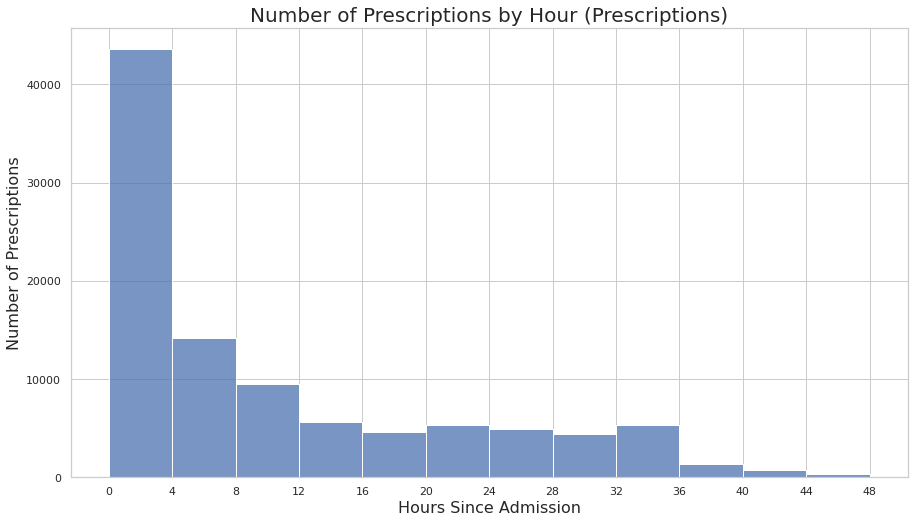

In [69]:
# Plotting events by hours (starttime - admittime)
fig, ax = plt.subplots()
sns.set(style="ticks", font_scale=1)
sns.histplot(data=drug, x='hour',bins=12, ax=ax)
ax.set_xticks(range(0,52,4))
plt.xlabel("Hours Since Admission", fontsize=16)
plt.ylabel("Number of Prescriptions", fontsize=16)
plt.title("Number of Prescriptions by Hour (Prescriptions)", fontsize=20)
plt.show(sns)